In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

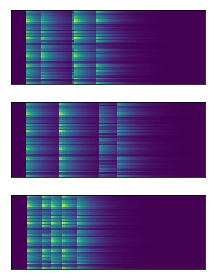

In [2]:
from twpca.datasets import jittered_population

data = jittered_population()[0] + jittered_population()[0]

fig, axes = plt.subplots(3, 1)
for ax, trial in zip(axes, data):
    ax.imshow(trial.T)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

In [3]:
from sklearn.decomposition import NMF

n_components = 2
K, T, N = data.shape
matrix = data.reshape(-1, N)
decomp = NMF(n_components=n_components)

V = decomp.fit_transform(matrix).reshape(K, T, n_components)
U = np.transpose(decomp.components_)

In [4]:
from twpca.warp import dba_align

V_template, warping_funcs, cost_hist = dba_align(V[:10], iterations=20)

100%|██████████| 20/20 [00:26<00:00,  1.30s/it]


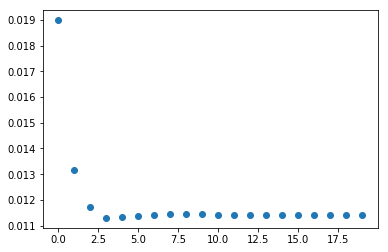

In [5]:
plt.plot(cost_hist, 'o')

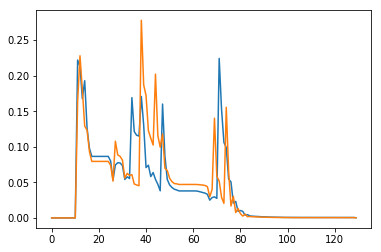

In [6]:
plt.plot(V_template)

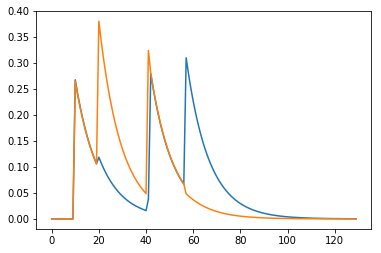

In [7]:
plt.plot(V[0])

In [3]:
from twpca import TWPCA
model = TWPCA(n_components=1)
cost_hist = model.fit(data)

ValueError: cannot reshape array of size 100 into shape (1,130,50)

In [9]:
cost_hist[0]

array([[ 0.        ,  0.        ,  0.        , ...,  0.47777295,
         0.43220898,  0.39099879],
       [ 0.        ,  0.        ,  0.        , ...,  0.47777295,
         0.43220898,  0.39099879],
       [ 0.        ,  0.        ,  0.        , ...,  0.47777295,
         0.43220898,  0.39099879],
       ..., 
       [ 0.54448022,  0.54448022,  0.54448022, ...,  0.51107498,
         0.49394249,  0.48124455],
       [ 0.4925225 ,  0.4925225 ,  0.4925225 , ...,  0.4818553 ,
         0.46225422,  0.44676485],
       [ 0.44553535,  0.44553535,  0.44553535, ...,  0.45773904,
         0.43583656,  0.41811314]])

In [6]:
K

100